### Flashcards

In [2]:
!pip install -q --upgrade transformers diffusers ftfy

In [3]:
!pip install huggingface_hub

In [4]:
from huggingface_hub import notebook_login

In [5]:
notebook_login()

In [6]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading the models

In [8]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

## Stable Diffusion Deep Dive

### A diffusion loop

In [9]:
# Some settings
prompt = ["Spider man fighting the hulk"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

In [10]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [11]:
text_input

{'input_ids': tensor([[49406,  7622,   786,  4652,   518, 17637, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [21]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [22]:
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.0596, -0.8660,  1.7193,  ..., -2.5590,  0.2351,  0.0746],
         [-0.0913, -0.1100,  1.5263,  ..., -2.8092,  0.1524,  0.2749],
         ...,
         [-0.9760,  0.0602,  1.1175,  ..., -0.0193, -1.7063, -0.4660],
         [-0.9780,  0.0664,  1.1049,  ..., -0.0212, -1.6885, -0.4940],
         [-0.9636,  0.0814,  1.1469,  ..., -0.0504, -1.7010, -0.4816]]],
       device='cuda:0')

In [41]:
text_embeddings.shape

torch.Size([3, 77, 768])

In [27]:
text_input.input_ids.shape

torch.Size([1, 77])

In [28]:
max_length = text_input.input_ids.shape[-1]

In [29]:
max_length

77

In [30]:
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

In [31]:
uncond_input

{'input_ids': tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [32]:
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 

In [39]:
uncond_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]],
       device='cuda:0')

In [40]:
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [35]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [37]:
text_embeddings.shape

torch.Size([3, 77, 768])

Prep Scheduler

In [49]:
num_inference_steps

30

In [48]:
scheduler.set_timesteps(num_inference_steps)

In [59]:
batch_size, unet.in_channels, height // 8, width // 8

(1, 4, 64, 64)

In [60]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator
)

In [62]:
latents.shape

torch.Size([1, 4, 64, 64])

In [65]:
scheduler.init_noise_sigma

tensor(14.6146)

In [67]:
latents = latents * scheduler.init_noise_sigma

In [74]:
scheduler.timesteps.shape

torch.Size([30])

### The Autoencoder (AE)

In [7]:
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

In [8]:
from torchvision import transforms as tfms

##### Example 1: Load and resize image

In [9]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  10509      0  0:00:05  0:00:05 --:--:-- 14643


In [10]:
from pathlib import Path

In [11]:
_im_path = Path('./macaw.jpg')

In [12]:
from PIL import Image

In [13]:
_im_path

PosixPath('macaw.jpg')

Write a function that load the image from a given path and resize it

In [14]:
def load_and_resize(path, size):
    return Image.open(path).resize(size)

In [15]:
_im = load_and_resize(_im_path, size=(64, 64))

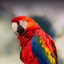

In [16]:
_im

##### Example 2: Turn image to tensor using torch vision

In [17]:
from torchvision import transforms as tfms

`_im` is a PIL Image. Write a function that turns a PIL Image to a tensor using `torchvision`

In [18]:
def im2tensor(im):
    return tfms.ToTensor()(im)

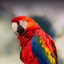

In [19]:
_im

In [20]:
_tensor = im2tensor(_im)

In [21]:
_tensor.shape

torch.Size([3, 64, 64])

##### back to lesson

In [22]:


def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

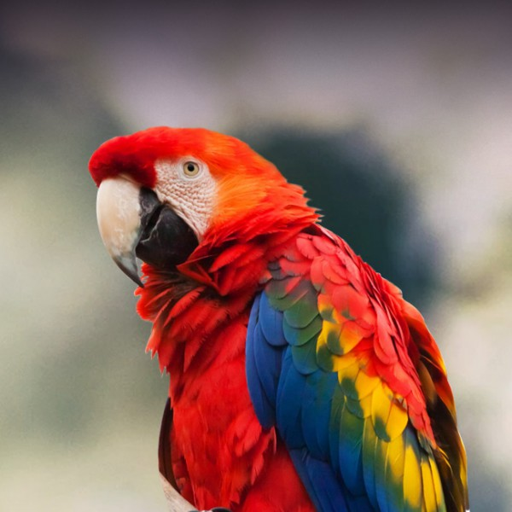

In [23]:
# Load the image with PIL


input_image = Image.open('macaw.jpg').resize((512, 512))


input_image

In [24]:
# Encode to the latent space
encoded = pil_to_latent(input_image)

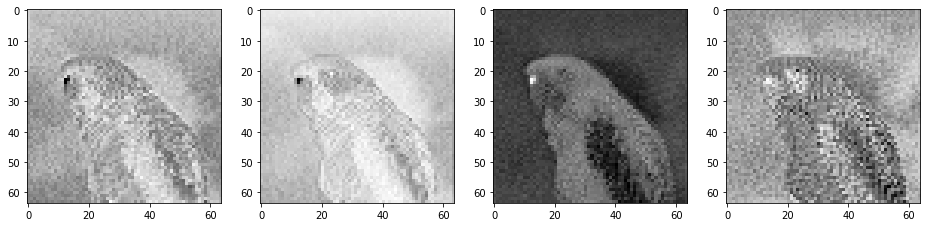

In [25]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

### Scheduler

##### Example 1

In [27]:
scheduler.set_timesteps(15)

In [28]:
scheduler.timesteps

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)

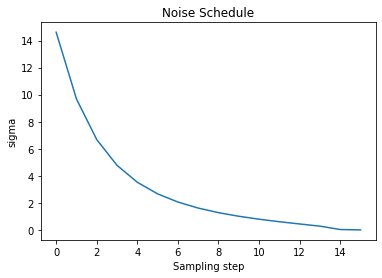

In [29]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

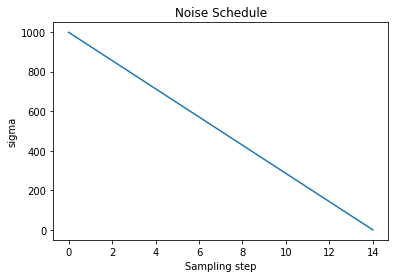

In [30]:
plt.plot(scheduler.timesteps)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

##### Example 1: Add noise to image

`encoded` is a compressed latent representation of an image. 

In [31]:
encoded.shape

torch.Size([1, 4, 64, 64])

In [32]:
noise = torch.randn_like(encoded)

In [33]:
sampling_step = 12

In [34]:
timesteps = torch.tensor([scheduler.timesteps[sampling_step]])

In [35]:
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=timesteps)

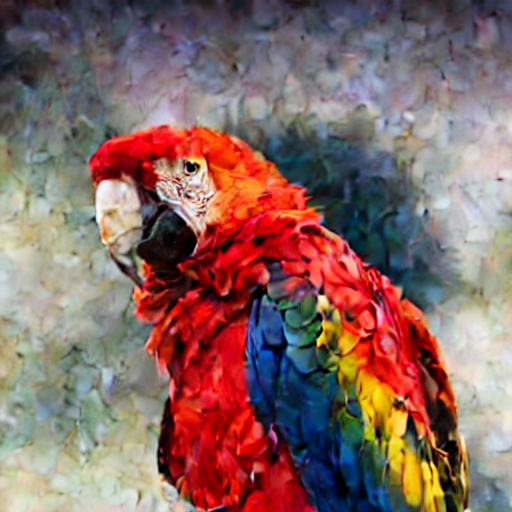

In [36]:
latents_to_pil(encoded_and_noised.float())[0]

### Loop starting from noised version of input (AKA image2image)


In [37]:
prompt = ["A colorful dancer, nat geo photo"]

In [38]:
height, width = 512, 512

In [39]:
num_inference_steps = 50

In [40]:
guidance_scale = 8

In [41]:
generator = torch.manual_seed(32)

In [42]:
batch_size = 1

0it [00:00, ?it/s]

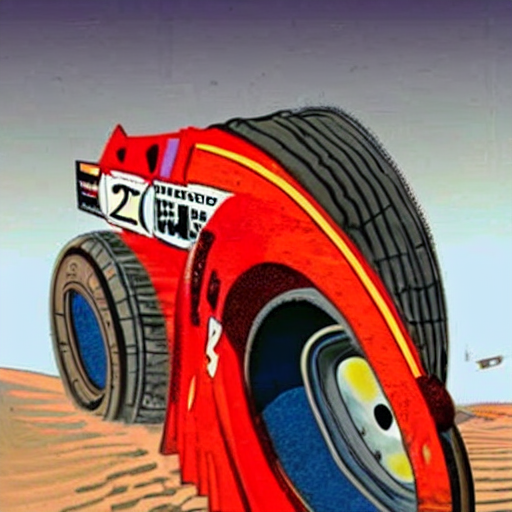

In [43]:
# Settings (same as before except for the new prompt)
prompt = ["A racing car on mars"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

### Exploring the text -> embedding pipeline

In [44]:
prompt = 'A picture of a puppy'

In [45]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [46]:
text_input['input_ids'][0]

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

See the individual tokens

In [54]:
for t in text_input['input_ids'][0][:8]:
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [57]:
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [58]:
output_embeddings.shape

torch.Size([1, 77, 768])

In [59]:
output_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [60]:
def text_to_output_embeddings(txt):
    toks = tokenizer(txt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    output_embeddings = text_encoder(toks.input_ids.to(torch_device))[0]
    return output_embeddings

In [61]:
text_to_output_embeddings('hello world')

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 1.4503,  0.1754, -1.5768,  ..., -0.6718, -0.6458, -0.3667],
         [ 0.4840, -1.7545, -0.6400,  ..., -0.2746,  0.3895, -1.6022],
         ...,
         [ 1.4271, -0.6755, -0.7845,  ...,  1.1314, -1.0441, -0.1540],
         [ 1.4454, -0.6613, -0.7752,  ...,  1.1475, -1.0329, -0.1609],
         [ 1.4247, -0.6040, -0.7417,  ...,  1.1230, -1.0609, -0.1902]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

### Token Embeddings

In [62]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

In [63]:
token_emb_layer

Embedding(49408, 768)

In [65]:
def txt_tokenzier(txt):
    return tokenizer(txt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [71]:
def token_to_token_embedding(toks):
    return token_emb_layer(toks.input_ids.to(torch_device))

In [86]:
toks = txt_tokenzier('hello world')

In [87]:
token_embeddings = token_to_token_embedding(toks)

### Positional Embedding

In [88]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

In [89]:
pos_emb_layer

Embedding(77, 768)

In [90]:
text_encoder.text_model.embeddings.position_ids

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76]], device='cuda:0')

In [91]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]

In [92]:
position_embeddings = pos_emb_layer(position_ids)

In [93]:
positional_input_embedding = token_embedding + position_embeddings

In [94]:
positional_input_embedding

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 1.2346e-02, -2.9068e-02,  9.0795e-03,  ...,  4.0386e-03,
           4.2618e-03,  1.1956e-03],
         [ 9.8995e-03,  2.5582e-02,  9.4527e-03,  ...,  2.0903e-02,
          -8.0610e-03, -1.7974e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)